# Project 3: Fraud Detection

In this third project, the main objective is to develop a fraud detection model capable of predicting fraudulent bank transactions. The implementation places particular emphasis on the following key areas:
- Unsupervised learning
- Semi-supervised learning
- Dealing with class imbalance
- Using advanced performance metrics to evaluate detection models under different inspection effort thresholds.

## Problem Understanding

The subject of fraud has always been a problem for the financial sector and with the ongoing technological advance, the problem will only increase. According to the [ Alloy’s 2024 State of Fraud Benchmark Report](https://www.alloy.com/state-of-fraud-benchmark-report-2024), which has asked more than 400 descision-makers in fraud-related roles, 57% of banks, fintechs, and credit unions lost over $500K in direct fraud losses in 2023. These figures reflect only the direct losses from fraud. That is, the actual amounts successfully stolen through fraudulent activity. 

In the UK, 10% of companies have lost between €1 and €100,000; 26% between €100,001 and €500,000; 34% between €500,001 and €1,000,000; 24% between €1,000,001 and €10,000,000; and 1% have suffered losses exceeding €10,000,000 due to fraud. Only 7 % reported no fraud loss, or simply don't know if they have.

Around 60% of the respondents reported an increase in the number of fraud attempts in consumer accounts compared to the previous year. Meanwhile, just over half the respondends have reported an increase in fraud attempts in business accounts.

The [UK Finance Annual Fraud Report 2022](https://www.ukfinance.org.uk/system/files/2023-05/Annual%20Fraud%20Report%202023_0.pdf) reported a net total loss £1.2 bn across the collective banking and finance industry in 2022 alone. This shows the damaging effects of fraud and emphazises the importance of fraud detection to prevent the enormous amounts of anual loss.

While the field has developed rapidly in the last few years, especially through the rise of artificial intelligence, there are still some challenges for successful fraud detection models. According to this article by the [Computer Science & IT Research Journal](https://fepbl.com/index.php/csitrj/article/view/1252), one major issue is the quality of datasets, especially due to the imbalance between fraudulent and legitimate activities, which can lead to biased or inaccurate predictions. Additionally, datasets suffer limited diversity or hidden biases, which skew model performances and undermine fairness. 

Overall, the problem of fraud and the importance of dealing with it through fraud detection systems is clear. The following sections of this notebook will focus on explring the data, understanding how to deal with class imbalance, as well as building and evaluating a fraud detection system using advanced techniques using unsupervised and semi-supervised learning.

In [4]:
# Includes
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ks_2samp

## Understanding the Data

The first thing to do is to take a closer look at the data that will be used to train the model later. Then, the data will be split into a test-train-val split before any further analysis.

In [111]:
# Load data
df = pd.read_csv("data/sales.csv")
df = df.set_index('Unnamed: 0') # set index
df.index.name = None
df

,ID,Prod,Quant,Val,Insp
1,v1,p1,182.0,1665.0,unkn
2,v2,p1,3072.0,8780.0,unkn
3,v3,p1,20393.0,76990.0,unkn
4,v4,p1,112.0,1100.0,unkn
5,v3,p1,6164.0,20260.0,unkn
...,...,...,...,...,...
411814,v5918,p4126,113.0,9330.0,unkn
411815,v2540,p4126,118.0,3355.0,unkn
411816,v5896,p4127,143.0,1835.0,unkn
411817,v1796,p4127,102.0,1445.0,unkn


In [6]:
# # Seperate labeled and unlabeled data
# labeled_df = df[df["Insp"].isin(["ok", "fraud"])].copy()
# unlabeled_df = df[df["Insp"] == "unkn"].copy()

# labeled_df

# # Split into X and y
# X = labeled_df.drop(columns="Insp")
# y = labeled_df["Insp"].map({"ok": 0, "fraud": 1})  # convert to binary

# # Split into train/test
# X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
#     X,
#     y,
#     test_size=0.25,
#     random_state=123,
#     stratify=y
# )

# use later during self supervised training

Before doing anything with the data, we split them into train and test set to prevent bias:

In [112]:
y = df["Insp"]
X = df.drop(labels=["Insp"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=123,
    stratify=y
)

In [8]:
y_train.unique()

array(['unkn', 'ok', 'fraud'], dtype=object)

In [9]:
print("Amount of unique vendors: ", len(X_train["ID"].unique()))
print("Amount of unique products: ", len(X_train["Prod"].unique()))

Amount of unique vendors:  5955
Amount of unique products:  4548


The data shows around 6000 unique vendors and around 4500 unique products. This makes it harder to encode the values for the model training phase.

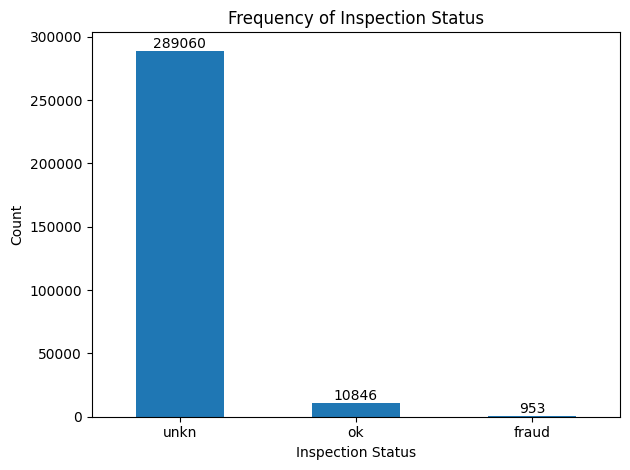

In [10]:
counts = y_train.value_counts() # get value counts for each unique "Insp" value

ax = counts.plot(kind="bar") # create plot

plt.xlabel("Inspection Status")
plt.ylabel("Count")
plt.title("Frequency of Inspection Status")
plt.xticks(rotation=0)

# plot actual values
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


The data is consists of a transaction Id("ID"), the products("Prod") bought with a quantity("Quant") and a the corresponding value("Val") spent during the transaction. For training, the id will not be necessary, but the rest can be used for preictions. A inspected value("Insp") flags the transaction as 'ok', 'fraud', or as 'unknown'. When looking at the value distribution, it can be seen that there is a significant amount of unknown data, and a small amount of data that is actually flagged as okay or fraudulent. This data imbalance needs to be addressed later.


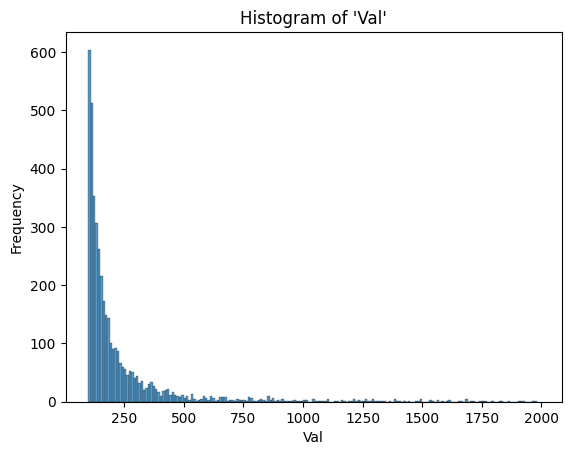

In [11]:
# val distribution
sns.histplot(X_train["Val"] / X_train["Quant"], bins=range(100, 2000, 10))
plt.title("Histogram of 'Val'")
plt.xlabel("Val")
plt.ylabel("Frequency")
plt.show()

The value distribution exposes strong tailed skewness to the left, which makes it harder to read this plot. This is to be expected, as in a real life scenario, smaller transactions are more common than larger ones. Apart from the value distribution, the quantity distribution looks like this:

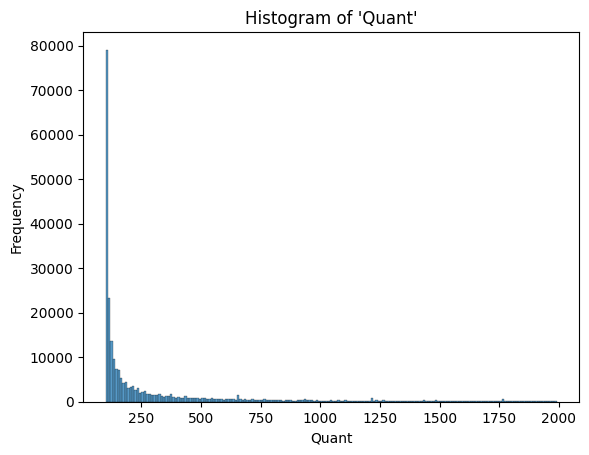

In [12]:
# quant distribution
sns.histplot(X_train["Quant"], bins=range(100, 2000, 10))
plt.title("Histogram of 'Quant'")
plt.xlabel("Quant")
plt.ylabel("Frequency")
plt.show()

The quantity distribution shows similar results to the value distribution, it is highly skewed to the left side. Overall, the skewness is not necessarily bad, as it represents real life circumstances. Despite that, removing the skewness could still be considered in case of bad prediction performance later.

Now let's look at the number of transactions per vendor as well as per product:

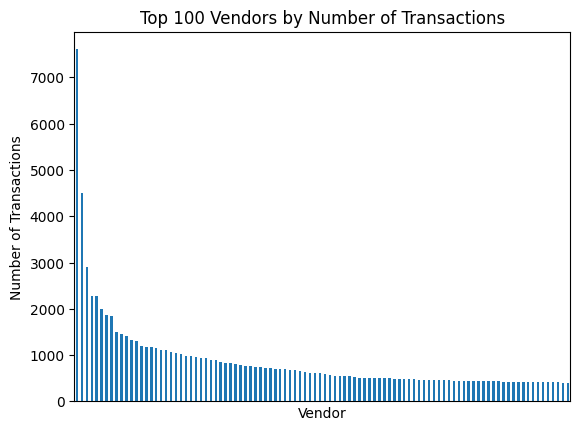

In [13]:
# transactions per vendor
vendor_counts = X_train.groupby("ID").size().sort_values(ascending=False)

# plot
vendor_counts.head(100).plot(kind="bar")
plt.title("Top 100 Vendors by Number of Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Vendor")
plt.xticks([], [])  # remove massive amount of ticks
plt.xticks(rotation=45)
plt.show()

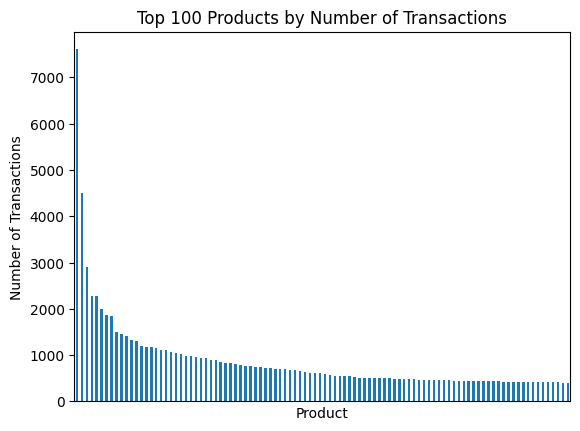

In [14]:
# transactions per product
prod_counts = X_train.groupby("Prod").size().sort_values(ascending=False)

# plot
vendor_counts.head(100).plot(kind="bar")
plt.title("Top 100 Products by Number of Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Product")
plt.xticks([], [])  # remove massive amount of ticks
plt.xticks(rotation=45)
plt.show()

Plotting the top 100 vendors/products by number of transactions reveals long tailed skewness again, just like before during the value and quantity distribution. This is again applicable for real life scenario, where a small percentage of customers make far more transactions than the rest. Although this data represents a real life scenario, it could lead to some problems later, during the semi-supervised learning approaches. Training the model on data that is heavily skewed towards a small amount of costumers may have a strong bias towards them. Therefore, some pre-processing will be necessary in order to prevent this from happening.

## Data Grouping and Feature Engineering

In this section, some data grouping and feature engineering is performed before training a model. Due to the fact that there are so many differnet products present in the data, grouping transactions per product might improve prediction quality.

In [113]:
X_train['Uprice'] = X_train['Val'] / X_train['Quant']

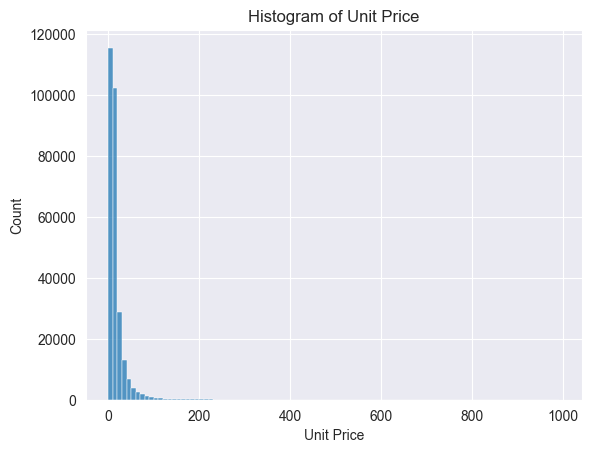

In [16]:
# plot unit price histogram
sns.set_style("darkgrid")

ax = sns.histplot(X_train["Uprice"], bins=range(1,1000,10))
plt.title("Histogram of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Count")
plt.show()

As in the previous histograms, the estimated unit price is also right-skewed. This further highlights the need to address the class imbalance later. Before that, missing values in the data are examined now.

In [17]:
X_train.isnull().any()

ID        False
Prod      False
Quant      True
Val        True
Uprice     True
dtype: bool

In [18]:
null_rows = X_train[X_train.isnull().any(axis=1)]
null_rows

,ID,Prod,Quant,Val,Uprice
342516,v614,p3478,NaN,1015.0,NaN
386456,v2694,p2126,NaN,1285.0,NaN
202471,v1981,p3164,NaN,1240.0,NaN
169552,v891,p3871,NaN,1035.0,NaN
302068,v1141,p1471,NaN,NaN,NaN
...,...,...,...,...,...
106715,v426,p2909,NaN,1015.0,NaN
93131,v1136,p1915,NaN,1020.0,NaN
197437,v819,p2693,NaN,1040.0,NaN
273015,v431,p3928,NaN,1065.0,NaN


The data contains 10586 rows with NaN in either the quantity or value column. This is only a small portion of the data, therefore they could safely be removed. Despite that, the values could be estimated instead. For now, let's create a copy of the data with removed values and keep the dataframe including the NaN values too.

In [19]:
X_train.isnull().sum()[X_train.isnull().sum() > 0]

Quant     10368
Val         881
Uprice    10586
dtype: int64

In [20]:
rows_with_multiple_nulls = X_train.isnull().sum(axis=1)
num_rows = (rows_with_multiple_nulls == 3).sum() # 3 because "Quant", "Val", "UPrice" need to be NaN to count 
print(f"{num_rows} rows have missing values for Quant and Val")

663 rows have missing values for Quant and Val


NaN values seem to be more prevelant in the quantity column than in the value column, and with 663 rows with missing values in both column, most missing Val columns are also missing the quantity value. In sum, only a small percentage of the training data has null values, therefore this opens up the opportunity to delete the data. But before that, a look at the distribution of products with missing quantity is done.

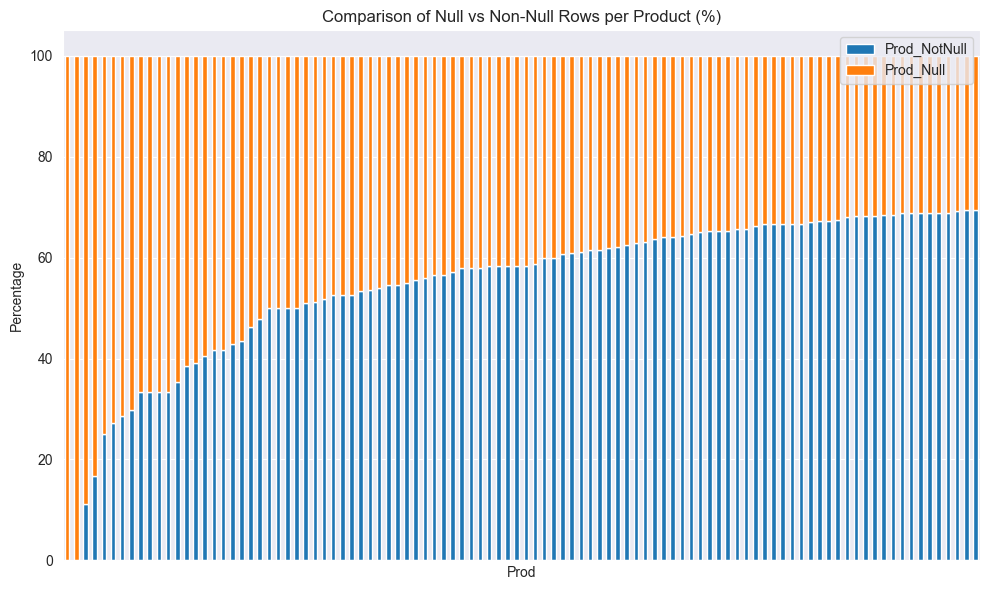

In [21]:
prod_nulls = X_train[X_train.isnull().any(axis=1)]["Prod"].value_counts() # value counts for null
prod_not_nulls = X_train[~X_train.isnull().any(axis=1)]["Prod"].value_counts() # value counts for not null

comparison = pd.DataFrame({
    "Prod_NotNull": prod_not_nulls,
    "Prod_Null": prod_nulls
}).fillna(0)
comparison = comparison[comparison["Prod_Null"] > 0] # remove products with zero null values

comparison_pct = comparison.div(comparison.sum(axis=1), axis=0) * 100
comparison_pct = comparison_pct.sort_values("Prod_Null", ascending=False).head(100)

comparison_pct.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Comparison of Null vs Non-Null Rows per Product (%)")
plt.ylabel("Percentage")
plt.xlabel("Prod")
plt.xticks([], [])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When looking at the percentage of null values per product, we can see that quite a few products have null for around half the available data, and some even have only NaN values. Just deleting the NaN rows will decrease the availability of data for specific products, thus limiting prediction quality. Keep in mind that this plot only shows rows where at least one column is missing, therefore a look at the percentag of columns, where both values are missing could help to decide if all NaN rows should be removed:

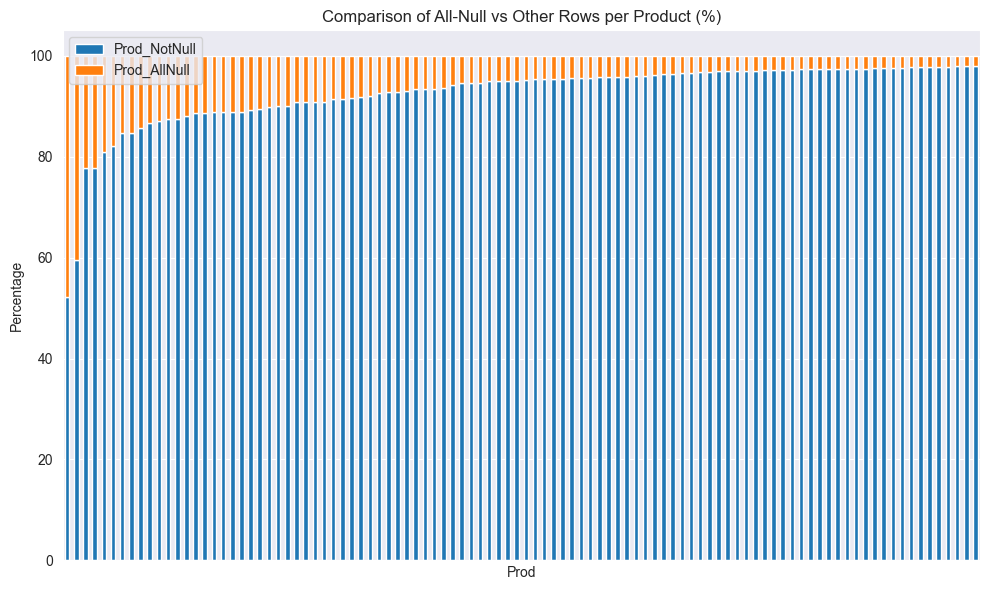

       Prod_NotNull  Prod_AllNull
Prod                             
p2689     52.173913     47.826087
p2675     59.459459     40.540541


In [22]:

mask_two_nulls = X_train.isnull().sum(axis=1) == 3 # mask for rows where two columns are missing values

prod_two_nulls = X_train[mask_two_nulls]["Prod"].value_counts() # value counts for null
prod_not_nulls = X_train[~mask_two_nulls]["Prod"].value_counts() # value counts for not null

comparison = pd.DataFrame({
    "Prod_NotNull": prod_not_nulls,
    "Prod_AllNull": prod_two_nulls
}).fillna(0)
comparison = comparison[comparison["Prod_AllNull"] > 0] # remove products with zero null values

comparison_pct = comparison.div(comparison.sum(axis=1), axis=0) * 100
comparison_pct = comparison_pct.sort_values("Prod_AllNull", ascending=False).head(100)

comparison_pct.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Comparison of All-Null vs Other Rows per Product (%)")
plt.ylabel("Percentage")
plt.xlabel("Prod")
plt.xticks([], [])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(comparison_pct.head(2))

The plot shows that the ratio is far better now for the rows where both Quant and Val are missing. Although for the product with the id p2689 and p2675, around 40-50 percent of the available transactions do not contain any value. This will heavily decrease their impact in the training data. Despite that, this indicates the possibility of removing all rows where both columns are missing. Columns with missing Val will be kept though, as they can be estimated later.

Finally, there is a case where a products quantity is not present in any row. Those rows need to be deleted too.

In [23]:
prods_all_quant_null = X_train.groupby("Prod")["Quant"].apply(lambda x: x.isnull().all()) # group by products with no valid quant
prods_to_remove = prods_all_quant_null[prods_all_quant_null].index

mask_no_quant = X_train["Prod"].isin(prods_to_remove) # mask all products where no valid quant
print(f"Number of rows with no quant: {(mask_no_quant).sum()}")

Number of rows with no quant: 41


Now to make this step reproducable, a function is implemented to filter out unwanted NaN rows.

In [103]:
def remove_NaN(X, y):
    """
    Removes rows with NaN when one of the following conditions is met:
    * Row contains NaN for both "Quant" and "Val"
    * Product contains only rows where "Quant" is NaN

    Parameters:
    X: Data representing input features
    y: Data representing output feature

    Returns:
    X: filtered
    Y: filtered
    """
    # remove rows where quant and val are null
    mask_nulls = X["Quant"].isnull() & X["Val"].isnull() # filter out rows with both quant and val missing.

    X = X[~mask_nulls]
    y = y[~mask_nulls]

    # remove rows where product with no valid quant values exists.
    prods_all_quant_null = X.groupby("Prod")["Quant"].apply(lambda x: x.isnull().all())
    prods_to_remove = prods_all_quant_null[prods_all_quant_null].index

    # Get all rows from X_train for those products
    mask_keep = ~X["Prod"].isin(prods_to_remove)

    X = X[mask_keep]
    y = y[mask_keep]

    return X, y

In [114]:
X_train, y_train = remove_NaN(X_train, y_train)
X_test, y_test = remove_NaN(X_test, y_test) # dont use yet, just remove NaN for later

In summary, the following rows with null values were removed or kept:
- Removed rows were both quantity and value are missing
- removed rows were a product has not a single valid quantity value
- Kept rows were only the quantity value (and therefore unit price) is NaN

## Outlier detection using boxplot

In this section, the goal is to identify outliers in the unit prices. For this, it is assumed that unit prices are following a near-normal distribution, where outliers would not match this pattern, which indicates fraud. This can easily be done by plotting a boxplot, as it makes it easy to detect outliers through median, interquartile range and the outliers.

Before any further steps are performed, the values already marked as fraudulent are removed, as they are not be representative. Additionally, products with too few transactions are also removed, as they skew the results.

In [65]:
_RARE_THRESHOLD = 15

In [115]:
def prepare_outlier_analysis(X, y):
    """
    Removes rows flagged as fraud and removed rows for products will few transaction (n <= 15)

    Parameters:
    X: Data representing input features
    y: Data representing output feature

    Returns:
    X: filtered input data
    Y: filtered output data
    X_removed: removed input rows
    y_removed: removed output rows
    """
    # mask rows flagged as fraud
    mask_fraud = y == "fraud" 
    
    # mask rare products
    product_counts = X['Prod'].value_counts()
    rare_products = product_counts[product_counts <= _RARE_THRESHOLD].index # removing rows n <= 5
    mask_rare_prod = X['Prod'].isin(rare_products)

    # combine masks
    mask_remove = mask_fraud | mask_rare_prod

    
    # apply combined mask
    X_filtered = X[~mask_remove]
    y_filtered = y[~mask_remove]

    X_removed = X[mask_remove]
    y_removed = y[mask_remove]
    
    return X_filtered, y_filtered, X_removed, y_removed

In [116]:
# remove specified rows from training data before outlier detection.
X_train, y_train, X_removed, y_removed = prepare_outlier_analysis(X_train, y_train)

After cleaning the data, it is time to determine the outliers. Using the properties of a boxplot, an outlier can be defined as the area above or below the whiskers. This is defined as lower = Q1 + 1.5 * IQR and upper = Q3 + 1.5 * IQR. Therefore, values in that range are outliers and can be flagged as outliers. This is done by implementing a function for calculatign the measures of central tendency and spread.

In [109]:
def add_boxplot_stats(X):
    """
    Computes boxplot features and addsthem to the fraud detection data

    Parameters:
    X: Data representing input features

    Returns:
    X: X with added boxplot features
    """
    # calculate quartiles
    q1 = X['Uprice'].quantile(0.25)
    q3 = X['Uprice'].quantile(0.75)

    iqr = q3 - q1     # calculate interquartiel range
    lower = q1 - 1.5 * iqr # lower whisker
    upper = q3 + 1.5 * iqr # upper whisker

    median = X['Uprice'].median() #calcualte median

    return pd.Series({'q1': q1, 'q3': q3, 'iqr': iqr, 'lower': lower, 'upper': upper, 'medP': median})

In [ ]:
# First, a function is implemented to calculate the boxplot values for each product
# Then, the boxplot stats are applied to each row given the product id.
def add_boxplot_stats(X):
    """
    Computes boxplot features and addsthem to the fraud detection data

    Parameters:
    X: Data representing input features

    Returns:
    X: X with added boxplot features
    """
    # calculate quartiles
    q1 = X['Uprice'].quantile(0.25)
    q3 = X['Uprice'].quantile(0.75)

    iqr = q3 - q1     # calculate interquartiel range
    lower = q1 - 1.5 * iqr # lower whisker
    upper = q3 + 1.5 * iqr # upper whisker

    median = X['Uprice'].median() # get median

    return pd.Series({'q1': q1, 'q3': q3, 'iqr': iqr, 'lower': lower, 'upper': upper, 'medP': median})

# This function takes X and y as inputs, and marks outliers as fraud.
def flag_outliers(X, y):
    """
    Flags outliers as fraud using boxplot measurements 

    Parameters:
    X: Data representing input features
    y: Data representing output features

    Returns:
    y: y with "fraud" values for outliers
    """
    # apply boxplot stats
    X_boxplot = X.groupby('Prod').apply(add_boxplot_stats).reset_index()
    print(X_boxplot.columns.tolist())
    X = X.merge(X_boxplot, on='Prod', how='left') # add outliers to dataframe

    # mask outliers above or below whiskers of the current product
    outlier_mask = (X['Uprice'] < X['lower']) | (X['Uprice'] > X['upper'])

    # reset index after merge due to error
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # Apply it to y_train_bp safely
    y.loc[outlier_mask] = "fraud"
    return X, y


In [117]:
# flag outliers as fraud
X_train, y_train = flag_outliers(X_train, y_train)

['Prod', 'q1', 'q3', 'iqr', 'lower', 'upper', 'medP']


C:\Users\nikla\AppData\Local\Temp\ipykernel_21856\4253948184.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_boxplot = X.groupby('Prod', group_keys=False).apply(add_boxplot_stats).reset_index()


Finally, the previously removed rows that were marked as fraud already or were removed due to a low amount of transactions per product are readded.

In [120]:
X_train = pd.concat([X_train, X_removed]).reset_index(drop=True)
y_train = pd.concat([y_train, y_removed]).reset_index(drop=True)

## Rare Products Through Product Similarity

In this chapter, the problem of rare product data by grouping them with similar products. The goal of this is to boost the reliability of the model in the case of predictions when rare products are involved. The idea here is to group the data based on the distribution of of unit prices across the products. Here, the measurements of central tendencies and spread can be used, just like for the boxplot analysis. Finally, a Kolmogorov-Smirnov-Test is used to determine similarity across two distributions in order to determine the most similar product. 

In [121]:
def rare_product_similarity_grouping(X):
    """
    Groups rare products by similarity

    Parameters:
    X: Data representing input features

    Returns:
    similarity: similarity list for rare products
    """
    # mask rare products
    product_counts = X['Prod'].value_counts()
    rare_products = product_counts[product_counts <= _RARE_THRESHOLD].index
    all_products = product_counts.index
    
    # compute median and IQR
    stats = (
        X.groupby('Prod')['Uprice'].agg(median='median', q1=lambda x: x.quantile(0.25), q3=lambda x: x.quantile(0.75)) # calculate metrics per product using lambda function
    )
    stats['iqr'] = stats['q3'] - stats['q1']
    stats = stats[['median', 'iqr']]

    # loop through rare products
    results = []
    for prod in rare_products:
        if prod not in stats.index: # if stats can't be computed
            continue # skip

        # get median and iqr for current product
        med_p = stats.loc[prod, 'median']
        iqr_p = stats.loc[prod, 'iqr']

        # calculate distance to other products
        stats['distance'] = np.sqrt((stats['median'] - med_p)**2 + (stats['iqr'] - iqr_p)**2)

        # calculate most similar product
        stats_sorted = stats.sort_values('distance')
        sim_prod = stats_sorted.index[1]  # second closest is most similar, exclude product itself

        med_s = stats.loc[sim_prod, 'median']
        iqr_s = stats.loc[sim_prod, 'iqr']

        # get product price and most similar product price
        prices_p = X[X['Prod'] == prod]['Uprice']
        prices_s = X[X['Prod'] == sim_prod]['Uprice']

        # carry out Kolmogorov-Smirnov-Test
        ks_stat, ks_pval = ks_2samp(prices_p, prices_s)

        # add to results
        results.append({
            'RowSimProd': stats_sorted.iloc[1]['distance'],
            'SimProd': sim_prod,
            'ks.stat': ks_stat,
            'ks.pval': ks_pval,
            'medP': med_p,
            'iqrP': iqr_p,
            'medS': med_s,
            'iqrS': iqr_s,
        })

    # return list of similarity
    similar = pd.DataFrame(results, index=rare_products)
    return similar

In [122]:
similar = rare_product_similarity_grouping(X_train)
similar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1054 entries, p4237 to p2745
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RowSimProd  1054 non-null   float64
 1   SimProd     1054 non-null   object 
 2   ks.stat     733 non-null    float64
 3   ks.pval     733 non-null    float64
 4   medP        1054 non-null   float64
 5   iqrP        1054 non-null   float64
 6   medS        1054 non-null   float64
 7   iqrS        1054 non-null   float64
dtypes: float64(7), object(1)
memory usage: 74.1+ KB


In [88]:
similar

,RowSimProd,SimProd,ks.stat,ks.pval,medP,iqrP,medS,iqrS
Prod,,,,,,,,
p4254,0.278934,p876,NaN,NaN,9.740061,7.648240,9.513274,7.810635
p704,0.607384,p1974,0.388889,0.138869,19.512635,16.708795,19.443867,16.105316
p398,0.127756,p2314,NaN,NaN,9.533898,3.001996,9.619048,2.906753
p1570,0.172772,p3625,NaN,NaN,13.414634,4.551659,13.514851,4.410922
p4296,0.258865,p3097,0.400000,0.106338,15.118159,4.878196,15.233615,4.646504
...,...,...,...,...,...,...,...,...
p2538,0.087315,p429,0.363636,0.255691,3.626506,1.897063,3.570947,1.829704
p1065,0.039491,p2742,NaN,NaN,10.841289,4.949063,10.801887,4.946408
p4233,0.040000,p1653,NaN,NaN,10.793333,0.000000,10.833333,0.000000


With the calculated similarity data, the median and iqr of the products for which similar products were calculated, can be replaced with the values from the SimProd product. They are stored in a seperate column here, to make it easier to preserve the original data.

In [ ]:
# get rare products from similar index
rare_products = similar.index

# reset index of similar and store in seperate variable
similar_reset = similar.reset_index()

# Mapping rare product to median and IQR
med_map = dict(zip(similar_reset['Prod'], similar_reset['medS']))
iqr_map = dict(zip(similar_reset['Prod'], similar_reset['iqrS']))

# calculate new corrected median 
X_train['medP_corrected'] = X_train.apply(
    lambda row: med_map[row['Prod']] if row['Prod'] in med_map else row['medP'],
    axis=1
)

# calculate new corrected iqr 
X_train['iqr_corrected'] = X_train.apply(
    lambda row: iqr_map[row['Prod']] if row['Prod'] in iqr_map else row['iqr'],
    axis=1
)

Now to summarize, a boxplot analysis was used to mark outliers as fraud and after that, rare products were grouped by similarity to other products and then their median and iqr were replaced with the similar products values.

In order to make any assumptions about outliers, a ranking will be created, but because the scales of different products vary, it is not feasable to just compare their values as they are. This problem can be solved using Normalized Distance to Typical Price (NDTP), which normalizes the deviation of each product, resulting in a unit-less value that can be ranked.

In [ ]:
X_train['NDTP'] = (X_train['Uprice'] - X_train['medP']) / X_train['iqr']
X_train_sorted = X_train.sort_values('NDTP', ascending=False)

## Semi-Supervised Learning Approaches


In this section, some semi-supervised learning techniques are implemented, that try to deal with the problem of inbalance in the data. To start things off, a self supervised training is used. In this approach, a model is trained only on the labeled data that is available. After that, the most confident predictions will be added to the labeled data. This way, new labeled data can be created, which makes the model more balanced. Now let's start with a random forest model as baseline.

In [36]:
threshhold = 0.95 # 95% confidence threshhold for predictions

rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(X_train_labeled, y_train_labeled) # train on labeled data

pred = rf.predict_proba(unlabeled_df[X.columns])[:, 1] # predict unlabeled data 

NameError: name 'X_train_labeled' is not defined